<h1 align=center>Gun Violence Policy: What Gives the Most Bang for Your Buck?</h1>

<h3 align=center>By Caleb Wheeler</h3>

<h2 align=center>Introduction</h2>

Accoding to NPR, as of May 10, 2021, there have been 194 mass shootings in the period from Jan. 1, 2021 to May 10, 2021. The consideration of mass shootings and the response that public bodies take in minimizing their damage and responding to them have become focal points of American society. K-12 schools across the country have adopted shooter drills to inhibit the quantity of deaths. After Parkland, Walmart adopted policies to restrict the sale of guns to all consumers under the age of 21, so as to pseudo-federalize age limitations. Clearly, many different entities are looking to reduce the quantity of mass shooting phenomena that occur, but what methods work, and what methods don't? Colorado was one of the first to formalize "red-flag laws," which allow for the sale of guns to be restricted to any persons deemed a threat to public safety by judicial process, and many political pundits argue that mental health program expansion reduces the probability of "snaps" that cause mass shootings. In this investigation, I'm going to teach you how to collect the data and find out.

### Part 1: Data Scraping and Wrangling

There are two approaches towards mass shooting legislation that are commonly seen within our media cycles: mass shooting reduction via mental health program expansion, and mass shooting reduction via stricter laws for acquiring and keeping guns. We would like to explore the effectiveness of both. To evaluate the effectiveness of mental health programs on mass shooting reduction, we need data on the quantity of mass shootings by state over time, and we need data on the quantity of funds spent on mental health programs by state over time. To evaluate the effectiveness of gun laws on mass shooting reduction, we need to find data representing the types of laws that each state has, prefferably over time, and reference it with the quantity of mass shootings that have occurred.

Have questions about red-flag laws? Read here: https://www.nytimes.com/2019/08/06/us/red-flag-laws.html

We'll begin by importing numpy to handle math, pandas to make tables from the data we get, pyplot to graph any useful information, and requests and regular expressions to parse html.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import re

<b>First, we'll search for data related to mass shootings and policy addressing them.</b>

In [2]:
mortality_table = pd.read_csv("./320_data/firearm_mortality_by_state.csv")
shootings_table = pd.read_csv("./320_data/mass_shootings_database.csv")

First, there's mortality_table. This table was collected by the CDC and provides statistics on the total known deaths and death per 100,000 people within a year by state. This can provide a multitude of insights, such as comparing whether mass shootings are phenomena similar to violent crime, which can have implications as to whether the same tactics that work for reducting crime reduce mass shootings.

The dataset is available here: https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm

In the code below, I'm dropping any data rows where the state is not specified. If the state is not specified, no attribution can be made towards where the event occurred, and regression would be ambiguous if some states have similar data, which makes imputation not feasible.

In [3]:
to_drop = []

# For every row of the table, drop it if the state data is missing
for index, row in mortality_table.iterrows():
    if type(row["STATE"]) != str:
        to_drop.append(index)
        
mortality_table = mortality_table.drop(to_drop)
mortality_table.head()

,YEAR,STATE,RATE,DEATHS,URL
0,2019.0,AL,22.2,1076.0,/nchs/pressroom/states/alabama/al.htm
1,2019.0,AK,24.4,179.0,/nchs/pressroom/states/alaska/ak.htm
2,2019.0,AZ,15.1,1136.0,/nchs/pressroom/states/arizona/az.htm
3,2019.0,AR,19.3,580.0,/nchs/pressroom/states/arkansas/ar.htm
4,2019.0,CA,7.2,2945.0,/nchs/pressroom/states/california/ca.htm


Next, we have shootings_table. This table is collected from the Gun Violence Archive. This dataset is <i>very</i> different to other mass shooting datasets due to its methodology. This database classifies a mass shooting as any event in which a perpetrator uses a gun to injure or kill 4 or more people. It collects occurrences of mass shootings through localized reporting, but it mandates the provision of official sources like a police report or government acknowledgement of the event to be counted, so it should, in theory, be reliable. I chose this specific dataset because most of them, like the Mother Jones database, only cover mass shootings that have massive media coverage, albeit in great detail.

This dataset will be used to count the number of occurrences of mass shootings by year and by state.

The dataset is available here: https://www.gunviolencearchive.org/mass-shooting

In [4]:
shootings_table.head()

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
0,1988326,"April 26, 2021",Oregon,Gresham,SE Stark St and SE 174th Ave,0,7,NaN
1,1987241,"April 26, 2021",Louisiana,Houma,656 Corporate Dr,0,5,NaN
2,1987235,"April 25, 2021",Alabama,Phenix City,1700 Highway 280 Bypass,0,4,NaN
3,1986593,"April 25, 2021",Arkansas,Little Rock,1900 E 6th St,1,3,NaN
4,1986770,"April 25, 2021",Missouri,Kansas City,E 18th St and Vine St,1,3,NaN


Once again, if the state is not present, the shooting cannot be attributed to any entity, and it would be difficult to use imputation, so the row is dropped. The same goes for the date of the event as far as difficulty of imputation, so if the event is missing, its row is also dropped.

In [5]:
to_drop = []

# Drop any row where the data is missing for the date or state
for index, row in shootings_table.iterrows():
    if (type(row["Incident Date"]) != str or type(row["State"]) != str):
        to_drop.append(index)
        
shootings_table = shootings_table.drop(to_drop)
shootings_table.head()

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
0,1988326,"April 26, 2021",Oregon,Gresham,SE Stark St and SE 174th Ave,0,7,NaN
1,1987241,"April 26, 2021",Louisiana,Houma,656 Corporate Dr,0,5,NaN
2,1987235,"April 25, 2021",Alabama,Phenix City,1700 Highway 280 Bypass,0,4,NaN
3,1986593,"April 25, 2021",Arkansas,Little Rock,1900 E 6th St,1,3,NaN
4,1986770,"April 25, 2021",Missouri,Kansas City,E 18th St and Vine St,1,3,NaN


And now, the hard part. We want to be able to study the effectiveness of mental health program expansion on reducing mass shootings, so we logically need data on mental health programs and spending by state by year. Well, we're in luck... partially, anyways. 

You see, there's this federal entity called the Substance Abuse and Mental Health Services Administrations (SAMHSA) that gives funding to the states to form mental health services, and they used to have a really neat API that details the funding given to each state by year. Now, that API is dead, or at the very least inaccessible. So how do we get the data?

Well, on this site here: https://www.samhsa.gov/grants-awards-by-state, SAMHSA provides a list of grant awards by state by year that happens to have a total mental health grant category. Swell! Now, we can use requests to extract the data from the multitude of sites. One problem though: how do we know what to extract? Well, looking through the HTML of each site, we can see that there is only one occurrence of total spending in the entire file, so we can simply use regular expressions to parse it! Technically, we could read the text here and organize it by tags, but since we know the source, and the structure of the website is non-traditional, it was easier to read the html of the site and figure out what to extract rather than create additional code to look for any differentiation in where total health funding appeared.

In [6]:
state_names = mortality_table.STATE.unique()
years = list(range(2014, 2021, 1))
health_spending = []

for year in years:
    for state in state_names:
        
        # Get specific URL of mental health data by state and year
        url = "https://www.samhsa.gov/grants-awards-by-state/"
        url = url + state + "/" + str(year)
        
        # Extract html from requests to the sites
        r = requests.get(url)
        text = r.text
        
        # Use regular expression to retrieve the totals for mental health funding
        searchObj = re.search("total-mental-health-funds\">\$((\d+,?)+)<", text)
        spending = searchObj.group(1)
        
        # Turn spending from a string to an integer
        spending = int(spending.replace(",", ""))
        
        health_spending.append((year, state, spending))

In [7]:
mental_health_table = pd.DataFrame.from_records(health_spending, columns = ['year', 'state', 'spending'])
mental_health_table.head()

,year,state,spending
0,2014,AL,8922933
1,2014,AK,2651640
2,2014,AZ,15771007
3,2014,AR,5464655
4,2014,CA,96178009


<b><i>And here, you can behold data on mental health spending by year by state.</i></b>

Other data that would be useful to have is information on how states restrict guns to persons of interest. It could be used to build a case about the effectiveness of strong restrictions in reducing the phenomena. Normally, this would be quite difficult to collect due to the subjective and categorical nature of classifying legal policies, but luckily someone has already done it for us.

https://www.statefirearmlaws.org/resources

This website compiled an Excel spreasheet of legal doctrine in each state by year that studies the state restrictions that prevent guns from being sold to or maintained by particular offenders. The classifications are a little too broad to use all of them, so we will just use the lawtotal column to count the total number of groups that states restrict guns to. The lawtotal column is effective because it provides a good aggregation in the form of a numerical value for how strict a state is in its gun sale restriction laws.

I should note that to use this data, the Excel sheet had to be turned into a CSV, and then the first lines had to be deleted so that Pandas could read the file.

In [8]:
gun_laws_table = pd.read_csv("./320_data/fiream_laws_by_state.csv")
gun_laws_table.head()

,state,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
0,Alabama,1991,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,15
1,Alabama,1992,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,16
2,Alabama,1993,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,16
3,Alabama,1994,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,16
4,Alabama,1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,16


Last but not least, we might want to have data on state populations by year, in the event of hidden variables. So, we acquire an Excel spreadsheet from the Census Bureau to give us this exact information:

https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_500989927

This Excel spreasheet is saved as a CSV, and the first couple rows until the state and year are dropped, alongside the estimation totals and exact totals. This is done because the first several rows contain no data, and interfere with Pandas and its parsing. Only the state columns and the columns by year from 2010 to 2019 are kept (because we need to know population by year, and it only goes up to 2019). Finally, Pandas is used to extract the information.

In [9]:
state_pops = pd.read_csv("./320_data/state_populations.csv")
state_pops.head()

,state,"2,010","2,011","2,012","2,013","2,014","2,015","2,016","2,017","2,018","2,019"
0,Alabama,"4,785,437","4,799,069","4,815,588","4,830,081","4,841,799","4,852,347","4,863,525","4,874,486","4,887,681","4,903,185"
1,Alaska,"713,910","722,128","730,443","737,068","736,283","737,498","741,456","739,700","735,139","731,545"
2,Arizona,"6,407,172","6,472,643","6,554,978","6,632,764","6,730,413","6,829,676","6,941,072","7,044,008","7,158,024","7,278,717"
3,Arkansas,"2,921,964","2,940,667","2,952,164","2,959,400","2,967,392","2,978,048","2,989,918","3,001,345","3,009,733","3,017,804"
4,California,"37,319,502","37,638,369","37,948,800","38,260,787","38,596,972","38,918,045","39,167,117","39,358,497","39,461,588","39,512,223"


If you notice, some tables use different formats for denoting the state. We can create a set of correspondences between the state being written out and the abbreviations to ease the translation.

In [10]:
state_abbrevs = pd.read_csv("./320_data/state_abbrevs.csv")
state_abbrevs.head()

,abbrev,name
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California


In [11]:
# Converts abbreviations for states to their full name with the first letter capitalize
ltrs_to_state = dict()

# Converts the full names of states to their abbreviations
state_to_ltrs = dict()

state_ltrs = state_abbrevs.abbrev.unique()
state_names = state_abbrevs.name.unique()

for i in range(len(state_ltrs)):
    ltrs_to_state[state_ltrs[i]] = state_names[i]
    state_to_ltrs[state_names[i]] = state_ltrs[i]

Here, we are extracting the year from the Incident Data column of our mass shootings table and adding it as another column. A lot of the data doesn't have a level of specificity below a year, so we really only need the year if we want to look at correspondences in the data.

In [12]:
date = []

# Extracts the year of the shooting occurrence, and stores to array to make column
for index, row in shootings_table.iterrows():
    date.append(re.search("\d{4}", row["Incident Date"]).group())
    
shootings_table["date"] = date
shootings_table.head()

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,date
0,1988326,"April 26, 2021",Oregon,Gresham,SE Stark St and SE 174th Ave,0,7,NaN,2021
1,1987241,"April 26, 2021",Louisiana,Houma,656 Corporate Dr,0,5,NaN,2021
2,1987235,"April 25, 2021",Alabama,Phenix City,1700 Highway 280 Bypass,0,4,NaN,2021
3,1986593,"April 25, 2021",Arkansas,Little Rock,1900 E 6th St,1,3,NaN,2021
4,1986770,"April 25, 2021",Missouri,Kansas City,E 18th St and Vine St,1,3,NaN,2021


### Part 2: Exploratory Data Analysis

In this stage of the data science pipeline, we look through the data we have in order to find relationships that might provide insights into how information changes alongside each other.

As we are studying the effectiveness of gun policies on mass shooting reduction, the first logical question is: do we actually have a problem with mass shootings? To re-iterate, we are using a database that classifies mass shootings as any gun violence event in which 4+ people are injured or killed. Perhaps one insight that can be had is whether the total deaths due to mass shootings has increased over time.

To find out, for each date, we take a subset of the mass shootings table. Then, we iterate through each row to compute a total count of casualties.

As we can see from the data below, there appears to be an increasing trend in the number of casualties due to mass shootings. While 2021 appears to decrease to historical levels, 2021 is still an ongoing year, and this dataset was collected as of April, so 2021 should be considered a full representation of the year.

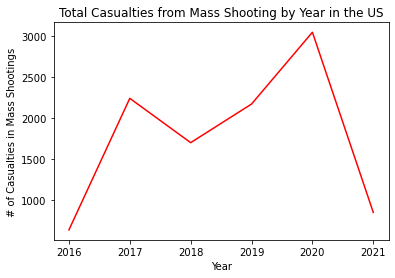

In [13]:
dates = sorted(shootings_table.date.unique())
mass_shootings = []

for date in dates:
    # Extract only entries in the shootings database for one year
    temp = shootings_table.loc[shootings_table["date"] == date]
    
    # Convert number of killed and injured to lists
    killed = temp["# Killed"].tolist()
    injured = temp["# Injured"].tolist()
    
    total = 0
    
    # Iterate through lists to count casualties in a year
    for i in range(len(killed)):
        total += killed[i] + injured[i]
        
    mass_shootings.append(total)
    
plt.plot(dates, mass_shootings, 'r')
plt.xlabel('Year')
plt.ylabel('# of Casualties in Mass Shootings')
plt.title("Total Casualties from Mass Shooting by Year in the US")
plt.show()

A logical extension of this data would also be to look at the quantity of mass shooting events by year. Once again, as 2021 is an unfinished year, it should not be considered in viewing the trends.

<b><i>As we can see, there is a clear increasing trend in both the numbers of people killed/injured by mass shootings, and in the frequency of mass shootings themselves</i></b>. This is a clear indication that the US has a growing problem with mass shootings.

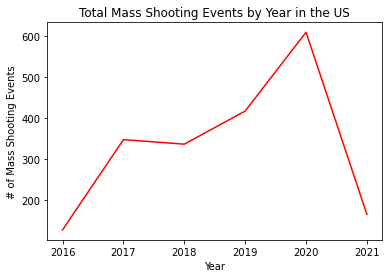

In [14]:
mass_shootings = []

for date in dates:
    
    # Extract shootings in a year, and get length of all shooting entries to count frequency
    temp = shootings_table.loc[shootings_table["date"] == date]       
    mass_shootings.append(len(temp["# Killed"].tolist()))
    
plt.plot(dates, mass_shootings, 'r')
plt.xlabel('Year')
plt.ylabel('# of Mass Shooting Events')
plt.title("Total Mass Shooting Events by Year in the US")
plt.show()

Now that we have data suggesting that mass shootings are a potentially growing problem, let's try and look at one of the proposed solutions: increasing mental health spending. Each state has a known amount of spending on mental health per year, and a known amount of shootings per year. So, we go through the table by state, and then construct the data such that each dollar corresponds to shooting frequencies.

Note: This appears to corroborate with the news. Read here: https://www.nbcnews.com/politics/meet-the-press/blog/meet-press-blog-latest-news-analysis-data-driving-political-discussion-n988541/ncrd1223551#blogHeader

In [15]:
brevs = []

# Create state abbreviations to add to the table to make cross-table references easier
for state in shootings_table["State"].tolist():
    brevs.append(state_to_ltrs[state])

shootings_table["Abbrev"] = brevs
shootings_table.head()

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,date,Abbrev
0,1988326,"April 26, 2021",Oregon,Gresham,SE Stark St and SE 174th Ave,0,7,NaN,2021,OR
1,1987241,"April 26, 2021",Louisiana,Houma,656 Corporate Dr,0,5,NaN,2021,LA
2,1987235,"April 25, 2021",Alabama,Phenix City,1700 Highway 280 Bypass,0,4,NaN,2021,AL
3,1986593,"April 25, 2021",Arkansas,Little Rock,1900 E 6th St,1,3,NaN,2021,AR
4,1986770,"April 25, 2021",Missouri,Kansas City,E 18th St and Vine St,1,3,NaN,2021,MO


In [16]:
state_spending_by_year = []

# Here, an array of dictionaries is being created in which each index is a year since 2016
# Each dictionary stores a list of states and their corresponding health spending for the year
for date in dates:
    state_spending = dict()
    temp = mental_health_table.loc[mental_health_table["year"] == int(date)]
    
    for index, row in temp.iterrows():
        state_spending[row["state"]] = row["spending"]
        
    state_spending_by_year.append(state_spending)

In [17]:
shootings_by_spending = dict()

for index, row in shootings_table.iterrows():
    
    # Restricts searching the parts of the table for which there is not health spending data
    if int(row["date"]) >= 2016 and int(row["date"]) < 2021:
        
        # This is specifically to avoid Washington DC, since it is not in the health spending dataset
        # The mod 2016 is to index based on years past 2016
        if row["Abbrev"] in state_spending_by_year[int(row["date"]) % 2016]:
            
            # Retrieves the mental health spending for the state during the year
            spent = state_spending_by_year[int(row["date"]) % 2016][row["Abbrev"]]
    else:
        continue
    
    # Counts the number of shooting occurrences that have occurred at a spending level
    if spent in shootings_by_spending:
        shootings_by_spending[spent] = shootings_by_spending[spent] + 1
    else:
        shootings_by_spending[spent] = 1

[]

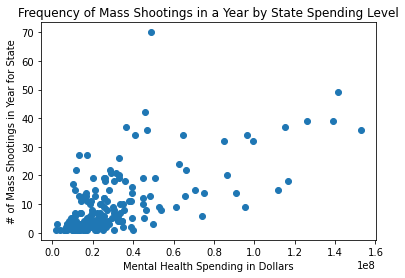

In [18]:
keys = list(shootings_by_spending.keys())
values = list(shootings_by_spending.values())

plt.scatter(keys, values)
plt.xlabel('Mental Health Spending in Dollars')
plt.ylabel('# of Mass Shootings in Year for State')
plt.title("Frequency of Mass Shootings in a Year by State Spending Level")
plt.plot()

<b><i>Wait... what?</i></b>

Is that suggesting what we think? Apparently, there appears to be an increasing trend between the amount of money that states spend on mental health, and mass shootings. Now, it is entirely possible that there simply is a relationship between health spending and violent events, but <b>I think it would be wise to see whether there is a confounding variable that is possibly correlated with both increased mental health spending and increased mass shootings.</b>

This illustrates some of issues that data scientists approach in the analysis part of the pipeline. It is entirely possible that data demonstrates relations with another variable, and that it can be used to imply many qualities. However, that does not necessarily mean that there is some particular quality of the data the requires that the other variable take on some quantity. The possibility of hidden variables is always present, and when experiments cannot be performed, information must always be checked for additional factors that affect its qualities.

To learn more about confounding variables: https://youtu.be/fjdb4ID7HVg

Let's try looking into what the relationship between population and mass shooting frequency is. I would imagine that larger states (population-wise) probably have more crazy people just by virtue of having more people, so it probably occurs there more frequently. I would also think that larger states probably have more to spend on mental health.

In [19]:
years = ['2,016', '2,017', '2,018', '2,019']
state_pops_by_year = []

# Creates an array of dictionaries in which each index represents a year past 2016
# Each dictionary holds the state population of a US state for a particular year
for year in years:
    state_pops_by_state = dict()
    
    for index, row in state_pops.iterrows():
        state_pops_by_state[row["state"]] = int(row[year].replace(',', ''))
        
    state_pops_by_year.append(state_pops_by_state)

In [20]:
shootings_by_pop = dict()

for index, row in shootings_table.iterrows():
    
    # Keeps the year range constrained to where data can be cross-referenced with the spending table
    if int(row["date"]) >= 2016 and int(row["date"]) < 2020:
        
        # Used to check if Washington D.C has appeared, which is not present in the spending table
        if row["State"] in state_pops_by_year[int(row["date"]) % 2016]:
            
            # Records the population of a state at a given year
            pop = state_pops_by_year[int(row["date"]) % 2016][row["State"]]
    else:
        continue
    
    # Counts the number of shootings that have occurred at a particular population level
    if pop in shootings_by_pop:
        shootings_by_pop[pop] = shootings_by_pop[pop] + 1
    else:
        shootings_by_pop[pop] = 1

[]

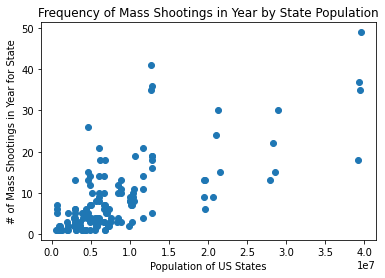

In [21]:
populations = list(shootings_by_pop.keys())
occs = list(shootings_by_pop.values())

plt.scatter(populations, occs)
plt.xlabel('Population of US States')
plt.ylabel('# of Mass Shootings in Year for State')
plt.title("Frequency of Mass Shootings in Year by State Population")
plt.plot()

Quite interestingly, the distribution of the shootings by population closely resembles the distribution of shootings by spending. It looks like we'll have to test whether there exists a significant relationship between population, mental health spending, and mass shootings where population and spending inform mass shooting frequencies. That said, there appears to be an increasing trend between the number of mass shootings in a state and population.

While, this chart does detail the relationship between population and mass shooting frequencies, it gives no information about where these mass-shooting are situated, and how they are distributed. By illustrating the specific locales of mass shootings, we can specify the regions where shootings are prevalent, and make better prediction based on other knowledge about the area.

Here, we illustrate the quantity of mass shootings that each of the states have had in the period of 2016-2021. As can be seen from the map, the mass shooting frequency appears to be highest in Illinois and California, and generally pretty high in the Mid-West/lower North-East by New York, Pennsylvania, and Ohio. After these regions, the South has a pretty low mass-shooting frequency, and the West/Great Plains has the lowest frequency of all the regions. Curiously, the states with among the highest mass shooting frequencies are California, New York, Illinois, Texas, Pennsylvania, and Ohio. Population-wise, these are very big states, which further demonstrates the relationship between population and mass shootings. Now, we know that these are mostly situated in states with many people, and that occurrences tend to drop in less populous regions.

In [22]:
import folium

# Retrieve GeoJSON that parititions the 50 US states and its territories
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"

# Get list of states
states = shootings_table.Abbrev.unique()

state_shooting_data = []

# For each state, count the number of mass shootings from 2016 to 2021
for state in states:
    temp = shootings_table.loc[shootings_table["Abbrev"] == state]
    
    state_shooting_data.append((state, temp.shape[0]))
    
state_shooting_table = pd.DataFrame(state_shooting_data, columns = ["State", "# of Shootings"])
state_shooting_table.head()

,State,# of Shootings
0,OR,6
1,LA,100
2,AL,52
3,AR,31
4,MO,70


In [23]:
m = folium.Map(location=[48, -102], zoom_start=3)

# Set the settings for the map
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_shooting_table,
    columns=["State", "# of Shootings"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Mass Shootings, 2016-2021",
).add_to(m)

folium.LayerControl().add_to(m)

m

Lastly, another common policy that people talk about is installing more restrictions on criminals and persons of interesting from purchasing or exchanging guns. One of our datasets happens to count how many distinct groups are restricted from purchasing guns based on a set of felonies and court actions, so we can collect the frequency of mass shootings in a state in a year by the quantity of restrictions a state has in a year.

In [24]:
state_laws_by_year = []

# Create a list of dictionaries in which each index represents a year
# Each dictionary stores the number of gun restrictions that a state
for date in dates:
    state_laws = dict()
    temp = gun_laws_table.loc[gun_laws_table["year"] == int(date)]
    
    for index, row in temp.iterrows():
        state_laws[row["state"]] = row["lawtotal"]
        
    state_laws_by_year.append(state_laws)

In [25]:
shootings_by_laws = dict()

for index, row in shootings_table.iterrows():
    
    # Constrains years to 2016-2020 to cross-reference data with the spending and population
    if int(row["date"]) >= 2016 and int(row["date"]) < 2021:
        
        if row["State"] in state_laws_by_year[int(row["date"]) % 2016]:
            
            # Retrieves the number of gun laws for a state in a year in 2016-2020
            laws = state_laws_by_year[int(row["date"]) % 2016][row["State"]]
    else:
        continue
    
    # Counts the number of shootings for every occurrence of law restriction totals
    if laws in shootings_by_laws:
        shootings_by_laws[laws] = shootings_by_laws[laws] + 1
    else:
        shootings_by_laws[laws] = 1

[]

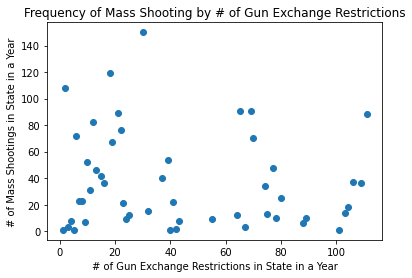

In [26]:
keys2 = list(shootings_by_laws.keys())
values2 = list(shootings_by_laws.values())

plt.scatter(keys2, values2)
plt.xlabel('# of Gun Exchange Restrictions in State in a Year')
plt.ylabel('# of Mass Shootings in State in a Year')
plt.title("Frequency of Mass Shooting by # of Gun Exchange Restrictions")
plt.plot()

There appears to be a non-obvious, somewhat static-looking relationship between gun restrictions and shooting events. It looks like we'll have to test whether there exists a significant relationship where gun restrictions affect shooting frequency.

### Part 3: Hypothesis Testing

In this part of the data science pipeline, we determine whether the effect that variables have on one another is different from what would be observed due to random chance, and we use this information to make prediction on how variables behave in relation to each other.

In the last section, we observed an extremely suspicious relationship in which mass shooting frequency appeared to increase with mental health spending and population. Now, we'll actually test whether there exists a significant relationship. The variables in question are distinctly numerical, and the zeroes are of relevance because 0 population means no people (and you can't have negative populations), and 0 occurrences means no shootings (and you can't have negative shootings). So, we are dealing with ratio variables here, and we want to find the change in shooting frequency for every unit change in these values. Thus, we should use multivariate regression to form a least-squares descriptor of the data. If the variance of this descriptor is low with respect to the number of samples, we can claim the the depicted relationship implies a significant difference from simple randomization. We could also use machine learning, but my objective is not to necessarily fit an optimal regression line for the purposes of prediction. My objective is to determine whether there is enough evidence to suggest a relationship, so I will instead use OLS, which contains packages for computing hypothesis testing, as it is faster to use to conduct the evaluation.

So, the null hypothesis that we are testing is: there exists no significant difference between the variation of mass shooting frequencies, mental health spending, and population, and the standard variance of the mass shooting frequencies. The alternative hypothesis is that there does exist a significant difference between the variances of the model of the variables and the standard variance of mass shooting frequencies.

To learn more about ANOVA Regression Testing: http://www.stat.yale.edu/Courses/1997-98/101/anovareg.htm

In [27]:
# Simplifies columns to avoid conversion with commas
state_pops.columns = ["state", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"]
state_pops.head()

,state,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Alabama,"4,785,437","4,799,069","4,815,588","4,830,081","4,841,799","4,852,347","4,863,525","4,874,486","4,887,681","4,903,185"
1,Alaska,"713,910","722,128","730,443","737,068","736,283","737,498","741,456","739,700","735,139","731,545"
2,Arizona,"6,407,172","6,472,643","6,554,978","6,632,764","6,730,413","6,829,676","6,941,072","7,044,008","7,158,024","7,278,717"
3,Arkansas,"2,921,964","2,940,667","2,952,164","2,959,400","2,967,392","2,978,048","2,989,918","3,001,345","3,009,733","3,017,804"
4,California,"37,319,502","37,638,369","37,948,800","38,260,787","38,596,972","38,918,045","39,167,117","39,358,497","39,461,588","39,512,223"


In [28]:
states = shootings_table.State.unique()
times = ["2016", "2017", "2018", "2019"]

data_triples = []
i = 0

for state in states:
    for time in times:
        if state == "District of Columbia":
            continue
        
        # Get the number of shooting events in a state in a given year
        temp = shootings_table.loc[(shootings_table["State"] == state) & (shootings_table["date"] == time)]
        events = temp.shape[0]
        
        # Get the number of amount that a state spends on mental heath in a year
        temp = mental_health_table.loc[(mental_health_table["state"] == state_to_ltrs[state]) & 
                                       (mental_health_table["year"] == int(time))]
        
        spending = temp.iloc[0]["spending"]
        
        # Get the population of a state in a year
        population = state_pops.loc[state_pops["state"] == state].iloc[0][time]
        
        # Add to list containing shooting frequency for every spending and population level
        data_triples.append((events,spending,int(population.replace(',', ''))))

In [29]:
shooting_data = pd.DataFrame(data_triples, columns=["events", "spending", "population"])
shooting_data.head()

,events,spending,population
0,0,13421590,4089976
1,0,13137677,4143625
2,0,22983948,4181886
3,1,25018974,4217737
4,5,17253972,4678135


In [30]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [31]:
# Produces a multilinear regression model where population and spending are the ind. variables
# and the shooting frequency is the dependent variable
model = ols("events ~ spending + population", shooting_data).fit()

print(model.summary())

# Runs the ANOVA F-Test for Multilinear Regression
anova_results = anova_lm(model)

print('\nANOVA results')
print(anova_results)

                            OLS Regression Results                            
Dep. Variable:                 events   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     105.8
Date:                Sat, 15 May 2021   Prob (F-statistic):           6.03e-31
Time:                        13:09:48   Log-Likelihood:                -574.97
No. Observations:                 180   AIC:                             1156.
Df Residuals:                     177   BIC:                             1166.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4949      0.657      0.753      0.4

Using the ANOVA F-Test on our multivariate model, we find that with alpha of 0.05, the P-values indicating the presence of a significant correlation between population, spending, and mass shootings indicate that there is a significant difference in both of the variables from randomization, so the null hypothesis is rejected. Therefore, <b>there is a positive relationship between population and mass shootings, and mental health spending and mass shootings.</b> However, as stated by the model summary, the condition number is large, so <b>it is highly likely that population and mental health spending are cross-correlated.</b>

Also within the last section, we saw a relationship between the number of restricted groups in gun purchases by law and the number of shooting events that appeared to have no correlation. We now want to test whether gun law restrictions actually affect mass shooting frequency. Both the number of shootings and laws cannot be negative, and the zeroes are meaningful because they represent a fundamental lack of action. So, both the response variable and the independent variable are ratio variables. To determine the correlation, we could fit the model using machine learning. However, we are at a distinct lack of significant training data, and the OLS package can already do univariate regression using least-squares, so it is ultimately unnecessary. Therefore, the OLS package will be used to conduct linear regression, and ANOVA will be used to do the hypothesis testing on the regression.

Here, we are testing whether there exists a significant difference in the variance of the regression models that details the quantity of shooting events with respect to gun restrictions from the variance of the data. Therefore the null hypothesis is: there exists no significant difference between the variance of the model and the variance of the data. The alternative hypothesis is that there does exist a significant difference.

In [32]:
# Produces tuples of the count of law restrictions and shootings to turn into a dataframe
data2 = zip(keys2, values2)

law_data = pd.DataFrame(data2, columns=["laws", "shootings"])
law_data.head()

,laws,shootings
0,12,82
1,42,2
2,70,70
3,30,150
4,103,14


In [33]:
# Produces a linear regression model where the number of restriction is the ind. variable
# and the shooting frequency is the dependent variable
model2 = ols("shootings ~ laws", law_data).fit()

print(model2.summary())

anova_results = anova_lm(model2)

print('\nANOVA results')
print(anova_results)

                            OLS Regression Results                            
Dep. Variable:              shootings   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.7168
Date:                Sat, 15 May 2021   Prob (F-statistic):              0.401
Time:                        13:09:48   Log-Likelihood:                -244.45
No. Observations:                  49   AIC:                             492.9
Df Residuals:                      47   BIC:                             496.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     43.0667      8.398      5.128      0.0

Using an alpha-level of 0.05, we fail to reject the null hypothesis. <b>This indicates that we cannot claim that there is a relationship between the number of restricted group in purchasing guns by law, and the number of mass shooting events</b>, as the model is not different enough from pure randomization.

### Part 4: Conclusion

Mass shootings are a problem that needs to be dutifuly addressed. The quantity of mass shooting events overall shows an increasing trend based on the charts that we were able to compute. However, this problem is very multifaceted, and the solution is not entirely clear. To re-iterate, two of the most common proposals for reducing the frequency of mass-shootings are through increasing access to mental health resources, and through installing more restrictions on threats to public safety from having legal access to guns. 

While no evidence has been presented that shows that higher mental health spending worsens shooting events, we have shown that there is a non-trivial increasing relationship between mental health spending by state and mass-shooting occurences. This is very likely due to the fact the states with higher populations objectively have more funding to spend on these programs, and have more mass shootings, but the issue remains that in states that can afford higher mental health spending, there is no sign of reduction of mass shooting occurrences relative to what is linearly predicted by states with lower populations and mental health funding.

On the matter of legal restrictions, based on the statistics collected here, there is no evidence that stronger laws on felons/legal threats for guns purchases affect the frequency of mass shootings. This is supported both by hypothesis testing, and intuitively. Looking at the map, state with relatively loose gun policies, like Nebraska or Montana, have practically little shootings compared to states with stricter policies, like New York or Maryland. That said, states with the looser policies tend to be small in population, so it is entirely possible that the reason why legal restriction have little effect is because population is the bigger confounding variable.

All in all, the available data shows that neither increasing legal restrictions on accessing guns nor increased mental health spending will have any great effect on reducing the quantity of mass shootings. As legislative policies, these solutions must be considered in tandem with other ideas that do show success in reducing mass shooting activity.

### References and Datasets

NPR Article: https://www.npr.org/2021/05/10/995380788/there-have-been-on-average-10-mass-shootings-in-the-u-s-each-week-this-year

Red-Flag Laws: https://www.nytimes.com/2019/08/06/us/red-flag-laws.html

NBC Report on Mass-Shootings:  https://www.nbcnews.com/politics/meet-the-press/blog/meet-press-blog-latest-news-analysis-data-driving-political-discussion-n988541/ncrd1223551#blogHeader

Confounding Variables Explanation: https://youtu.be/fjdb4ID7HVg

ANOVA Testing Page: http://www.stat.yale.edu/Courses/1997-98/101/anovareg.htm

Firearm Mortality: https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm

Mass Shooting Database: https://www.gunviolencearchive.org/mass-shooting

Mental Health Spending: https://www.samhsa.gov/grants-awards-by-state

State Firearm Laws: https://www.statefirearmlaws.org/resources

State Populations: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_500989927